<a href="https://colab.research.google.com/github/RoetGer/generalized-t-process-regression/blob/main/gen_t_process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install gpflow

     |████████████████████████████████| 276kB 7.5MB/s 


In [ ]:
import gpflow
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

plt.rcParams["figure.figsize"] = (12, 8)

tf.__version__

'2.5.0'

In [ ]:
df = 3.
loc = tf.Variable([1., 2., 3.])
scale = [[ 0.6,  0. ,  0. ],
         [ 0.2,  0.5,  0. ],
         [ 0.1, -0.3,  0.4]]
scale = tf.linalg.LinearOperatorLowerTriangular(scale)

mvt = tfd.MultivariateStudentTLinearOperator(
    df=df,
    loc=loc,
    scale=scale)

In [ ]:
with tf.GradientTape() as outer_tape:
  with tf.GradientTape() as inner_tape:
    density = mvt.prob([0., 0., 0.])
  gradient = inner_tape.gradient(density, mvt.trainable_variables[0])

outer_tape.jacobian(gradient, mvt.trainable_variables[0])

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[ 6.9320464e-07, -7.5581365e-06, -9.2025548e-06],
       [-7.5581352e-06,  1.9834491e-05,  2.5120040e-05],
       [-9.2025539e-06,  2.5120042e-05,  2.7110138e-05]], dtype=float32)>

In [ ]:
mvt.trainable_variables

(<tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([1., 2., 3.], dtype=float32)>,)

In [ ]:
loc.shape

TensorShape([3])

### GPflow - Binary Classification

Foundation taken from [GPflow binary classification model](https://gpflow.readthedocs.io/en/master/notebooks/basics/classification.html)

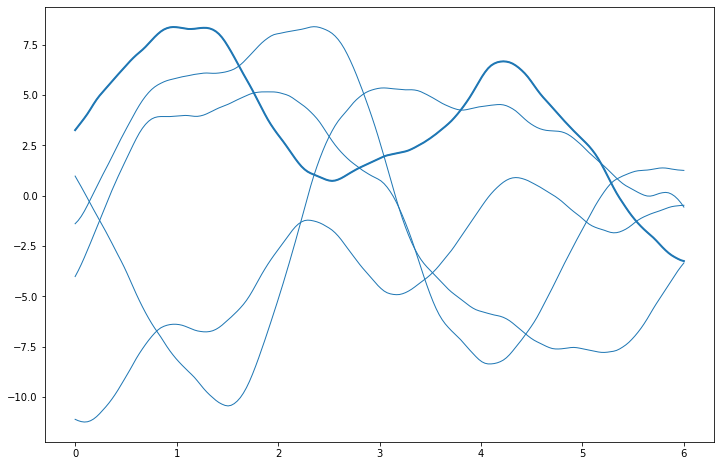

In [ ]:
# build the kernel and covariance matrix
k = gpflow.kernels.Matern52(variance=20.0)
x_grid = np.linspace(0, 6, 200).reshape(-1, 1)
K = k(x_grid)

# sample from a multivariate normal
rng = np.random.RandomState(6)

L = np.linalg.cholesky(K)
f_grid = np.dot(L, rng.randn(200, 5))
plt.plot(x_grid, f_grid, "C0", linewidth=1)
_ = plt.plot(x_grid, f_grid[:, 1], "C0", linewidth=2)

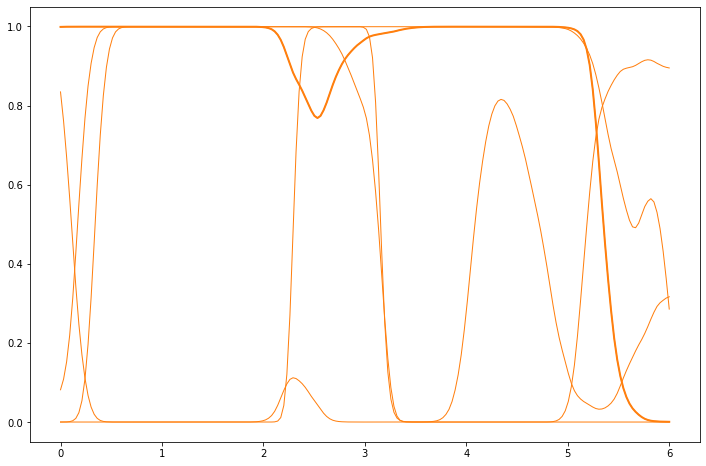

In [ ]:
def invlink(f):
    # By default, standard normal CDF is used as link function, but 
    # any other function can be used as well, just set invlink argument
    # of Bernoulli()
    return gpflow.likelihoods.Bernoulli().invlink(f).numpy()


p_grid = invlink(f_grid)
plt.plot(x_grid, p_grid, "C1", linewidth=1)
_ = plt.plot(x_grid, p_grid[:, 1], "C1", linewidth=2)

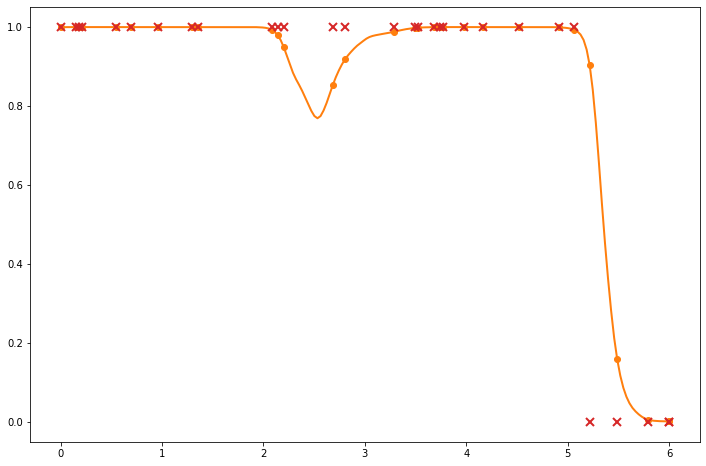

In [ ]:
# Select some input locations
ind = rng.randint(0, 200, (30,))
X_gen = x_grid[ind]

# evaluate probability and get Bernoulli draws
p = p_grid[ind, 1:2]
Y_gen = rng.binomial(1, p)

# plot
plt.plot(x_grid, p_grid[:, 1], "C1", linewidth=2)
plt.plot(X_gen, p, "C1o", ms=6)
_ = plt.plot(X_gen, Y_gen, "C3x", ms=8, mew=2)

In [ ]:
m = gpflow.models.VGP(
    (X_gen, Y_gen), likelihood=gpflow.likelihoods.Bernoulli(), kernel=gpflow.kernels.Matern52()
)

opt = gpflow.optimizers.Scipy()
opt.minimize(m.training_loss, variables=m.trainable_variables)

      fun: 5.921130177394291
 hess_inv: <497x497 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 6.78253795e-04, -1.61809166e-06,  7.97288934e-05, -2.56457370e-05,
       -3.19435981e-04, -9.77303768e-05,  3.65503836e-06, -3.55404475e-05,
        1.51691560e-06,  2.60414254e-06, -5.66910904e-07,  6.83518424e-07,
       -4.84583134e-06, -8.26329395e-07, -7.74970114e-06,  6.64908570e-06,
       -2.58952853e-07, -1.15593266e-05, -4.40631564e-07,  4.90943344e-07,
       -5.01536929e-09, -2.33588387e-09, -2.40253319e-06,  1.37008530e-07,
       -3.01552016e-07, -3.93965023e-07, -2.99033797e-08, -3.87416728e-08,
       -3.92586551e-08,  2.05379648e-08,  2.92843059e-06, -8.10135283e-08,
       -8.38028936e-08,  6.45942925e-16,  4.92766267e-11,  3.41825071e-15,
        5.14826996e-14, -3.38859041e-13,  1.52259895e-13,  9.40644512e-09,
       -2.80741643e-09,  6.83393397e-09,  5.31380897e-16, -2.47080565e-11,
        5.19857243e-13,  4.81490492e-09, -2.39469898e-08, -7.80634456e-10,


In [ ]:
m.training_loss()

<tf.Tensor: shape=(), dtype=float64, numpy=5.921130177394292>

In [ ]:
with tf.GradientTape() as tape:
  mll = m.maximum_log_likelihood_objective()

tape.jacobian(mll, m.trainable_variables)

In [ ]:
obs_dist = gpflow.likelihoods.Bernoulli(invlink=tf.math.sigmoid)

??obs_dist.predict_log_density

In [ ]:
obs_dist.log_prob(f_grid[:30,:1], Y_gen)

<tf.Tensor: shape=(30,), dtype=float64, numpy=
array([-1.61587877e+00, -1.48984477e+00, -1.33196346e+00, -3.79287935e-01,
       -4.79049744e-01, -7.88255854e-01, -6.32315490e-01, -5.01419843e-01,
       -3.91492380e-01, -3.03863486e-01, -2.35978500e-01, -1.81045085e-01,
       -1.36544524e-01, -2.32998985e+00, -7.63898726e-02, -5.71398647e-02,
       -4.30555024e-02, -3.25834221e-02, -2.46946565e-02, -3.98901426e+00,
       -1.42630033e-02, -1.10535643e-02, -8.75049693e-03, -7.11412427e-03,
       -5.93139030e-03, -5.07594011e-03, -4.47273717e-03, -4.04727220e-03,
       -5.59281770e+00, -3.47115426e-03])>

### GPC Laplace Approach

In [1]:
!pip install gpflow

     |████████████████████████████████| 271 kB 6.5 MB/s 


In [29]:
import gpflow
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.preprocessing import StandardScaler
tfd = tfp.distributions

plt.rcParams["figure.figsize"] = (12, 8)

tf.__version__

nobs = 50
PI = tf.constant(np.pi, dtype=tf.float64)
obs_dist = gpflow.likelihoods.Bernoulli(invlink=tf.math.sigmoid)

def gpc_posterior(f, y, K):
  pad_K = K + 10e-9*tf.eye(K.shape[0], dtype=tf.float64)
  chol_K = tf.linalg.cholesky(pad_K)
  fK = tf.linalg.cholesky_solve(chol_K, f)
  nobs = f.shape[0]

  ll = (
    tf.reduce_sum(obs_dist.log_prob(f, y))
    - 0.5*tf.matmul(f, fK, transpose_a=True)
    - tf.reduce_sum(tf.math.log(tf.linalg.diag_part(chol_K)))
    - 0.5*nobs*tf.math.log(2*PI)
  )

  return ll

def compute_posterior_covariance(K, hess_diag):
  sqrt_w = tf.sqrt(-hess_diag)
  sqrt_w_t = tf.reshape(sqrt_w, shape=(-1, 1))

  K_sqrt_w = tf.multiply(K, sqrt_w)
  B = tf.eye(K.shape[0], dtype=tf.float64) + tf.multiply(sqrt_w_t, K_sqrt_w)
  
  chol_B = tf.linalg.cholesky(B)
  K_sqrt_w_t = tf.transpose(K_sqrt_w)
  inv_sqrt_B_sqrt_w_K = tf.linalg.cholesky_solve(chol_B, K_sqrt_w_t)
#TODO:first inv_sqrt_B should probably just be K_sqrt_w_t, or so
  cov_mat = K - tf.matmul(
      inv_sqrt_B_sqrt_w_K, inv_sqrt_B_sqrt_w_K, transpose_a=True)
  
  return cov_mat

def compute_hess_vec_obs_ll(f, y):
  prod_vector = tf.repeat(tf.cast(1., dtype=tf.float64), repeats=f.shape[0])
  prod_vector = tf.reshape(prod_vector, shape=(-1,1))

  with tf.autodiff.ForwardAccumulator(
      f, prod_vector) as acc:
    with tf.GradientTape() as tape:
      obs_ll = tf.reduce_sum(obs_dist.log_prob(f, y))
    grad_obs_ll = tape.gradient(obs_ll, f)

  hess_vec = acc.jvp(grad_obs_ll)
  return tf.squeeze(hess_vec)

def compute_marginal_ll(f, y, K, hess_diag):
  sqrt_w = tf.sqrt(-hess_diag)
  sqrt_w_t = tf.reshape(sqrt_w, shape=(-1, 1))

  K_sqrt_w = tf.multiply(K, sqrt_w)
  B = tf.eye(K.shape[0], dtype=tf.float64) + tf.multiply(sqrt_w_t, K_sqrt_w)
  chol_B = tf.linalg.cholesky(B)

  chol_K = tf.linalg.cholesky(K  + 10e-6*tf.eye(K.shape[0], dtype=tf.float64))
  inv_chol_K_f = tf.linalg.cholesky_solve(chol_K, f)

  mll = (
      - 0.5*tf.tensordot(inv_chol_K_f, inv_chol_K_f, axes=(0, 0))
      + tf.reduce_sum(obs_dist.log_prob(f, y))
      - tf.reduce_sum(tf.math.log(tf.linalg.diag_part(chol_B)))
  )
  
  return mll

k = gpflow.kernels.SquaredExponential(lengthscales=1., variance=2.)
ssc = StandardScaler()
x_grid = ssc.fit_transform(np.linspace(0, 6, nobs).reshape(-1, 1))
x_grid = tf.constant(x_grid, dtype=tf.float64)
K = k(x_grid)

# sample from a multivariate normal
rng = np.random.RandomState(6)

L = np.linalg.cholesky(K + 10e-6*tf.eye(K.shape[0], dtype=tf.float64))
f_real = np.dot(L, rng.randn(nobs, 1))
f_real = tf.cast(f_real, tf.float64)

pvals = obs_dist.invlink(f_real)
y = tf.cast(rng.binomial(1, pvals), tf.int32)

In [30]:
x_grid.dtype

tf.float64

In [39]:
chol_K = tf.linalg.cholesky(K + 10e-12*tf.eye(K.shape[0], dtype=tf.float64))
inv_chol_K = tf.linalg.triangular_solve(chol_K, tf.eye(K.shape[0], dtype=tf.float64))


In [45]:
tf.linalg.diag_part(inv_chol_K @ tf.transpose(inv_chol_K) @ K)

<tf.Tensor: shape=(50,), dtype=float64, numpy=
array([-2.55298001e+03,  2.31539292e+05, -9.72103769e+06,  2.72478430e+08,
       -5.63242788e+09,  4.11804333e+10, -3.73871842e+10,  1.49553252e+10,
        2.31507568e+10, -1.73653321e+10, -1.21522923e+10,  1.74390097e+10,
        1.34443334e+10, -1.02200503e+10, -1.23343981e+10,  5.48735573e+09,
        1.21687291e+10,  1.01054159e+09, -9.30332750e+09, -4.51412063e+09,
        5.81422053e+09,  6.94575840e+09, -1.22821245e+09, -7.22179742e+09,
       -3.66096865e+09,  3.91675737e+09,  6.43119689e+09,  2.38500425e+09,
       -2.31903065e+09, -2.38519198e+09,  6.26029395e+08,  1.45550971e+09,
       -1.82162800e+09, -5.78609364e+09, -5.68648469e+09, -7.40076663e+08,
        5.32268794e+09,  8.53881528e+09,  7.98929712e+09,  5.29431994e+09,
        1.92608099e+09, -2.41434362e+09, -8.52116821e+09, -1.52513896e+10,
       -1.87836547e+10, -1.46020332e+10, -4.79206899e+08,  2.25615518e+10,
        5.19254183e+10,  8.49316952e+10])>

In [48]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
#X, y = load_iris(return_X_y=True)
kernel = 1.0 * RBF(1.0)
gpc = GaussianProcessClassifier(kernel=kernel,
         random_state=0).fit(x_grid, y.numpy().ravel())

In [50]:
gpc.score(x_grid, y)

0.8

In [38]:
??tf.linalg.triangular_solve

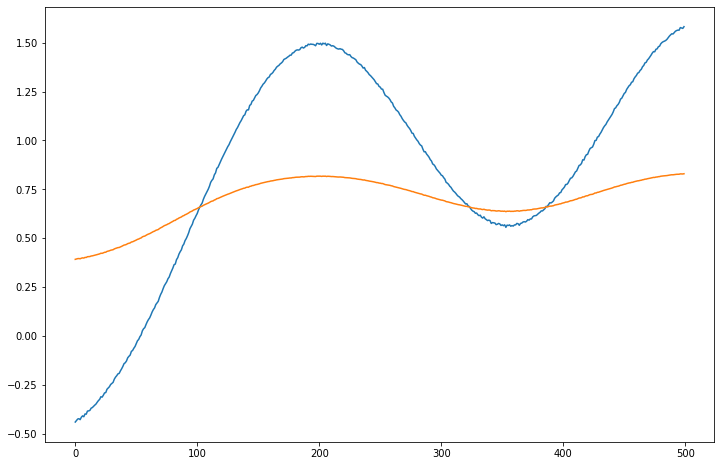

In [4]:
import matplotlib.pyplot as plt

plt.plot(f_real.numpy())
plt.plot(pvals.numpy())

In [8]:
np.linalg.eigvals(K + 10e-12*tf.eye(nobs, dtype=tf.float64))

array([5.75496544e+02+0.00000000e+00j, 2.93902237e+02+0.00000000e+00j,
       1.00640988e+02+0.00000000e+00j, 2.45999793e+01+0.00000000e+00j,
       4.57985378e+00+0.00000000e+00j, 6.84835573e-01+0.00000000e+00j,
       8.54751913e-02+0.00000000e+00j, 9.15199162e-03+0.00000000e+00j,
       8.57813649e-04+0.00000000e+00j, 7.14841479e-05+0.00000000e+00j,
       5.36169977e-06+0.00000000e+00j, 3.65603873e-07+0.00000000e+00j,
       2.28599007e-08+0.00000000e+00j, 1.32817098e-09+0.00000000e+00j,
       8.06023645e-11+0.00000000e+00j, 1.35266659e-11+0.00000000e+00j,
       1.01652232e-11+0.00000000e+00j, 9.97382208e-12+0.00000000e+00j,
       1.00160725e-11+1.35193933e-14j, 1.00160725e-11-1.35193933e-14j,
       9.99651000e-12+1.88818074e-14j, 9.99651000e-12-1.88818074e-14j,
       9.99010852e-12+1.08823108e-14j, 9.99010852e-12-1.08823108e-14j,
       9.98515804e-12+0.00000000e+00j, 9.98692077e-12+0.00000000e+00j,
       1.00128558e-11+1.40660253e-15j, 1.00128558e-11-1.40660253e-15j,
      

In [ ]:
K

<tf.Tensor: shape=(500, 500), dtype=float64, numpy=
array([[2.00000000e+00, 1.99985543e+00, 1.99942177e+00, ...,
        3.51777028e-08, 3.27363152e-08, 3.04599595e-08],
       [1.99985543e+00, 2.00000000e+00, 1.99985543e+00, ...,
        3.77956979e-08, 3.51777028e-08, 3.27363152e-08],
       [1.99942177e+00, 1.99985543e+00, 2.00000000e+00, ...,
        4.06026587e-08, 3.77956979e-08, 3.51777028e-08],
       ...,
       [3.51777028e-08, 3.77956979e-08, 4.06026587e-08, ...,
        2.00000000e+00, 1.99985543e+00, 1.99942177e+00],
       [3.27363152e-08, 3.51777028e-08, 3.77956979e-08, ...,
        1.99985543e+00, 2.00000000e+00, 1.99985543e+00],
       [3.04599595e-08, 3.27363152e-08, 3.51777028e-08, ...,
        1.99942177e+00, 1.99985543e+00, 2.00000000e+00]])>

In [ ]:
np.abs(np.divide(np.cov(np.dot(L, rng.randn(nobs, 10000))) - K, K))

array([[1.33706225e-03, 1.39394844e-03, 1.51256138e-03, ...,
        2.80186653e+05, 2.93162477e+05, 3.08926971e+05],
       [1.39394844e-03, 1.44149600e-03, 1.56570592e-03, ...,
        2.67062646e+05, 2.79471692e+05, 2.94499077e+05],
       [1.51256138e-03, 1.56570592e-03, 1.68104042e-03, ...,
        2.51908272e+05, 2.63637490e+05, 2.77845349e+05],
       ...,
       [2.80186653e+05, 2.67062646e+05, 2.51908272e+05, ...,
        5.68705005e-03, 5.64189609e-03, 5.59863747e-03],
       [2.93162477e+05, 2.79471692e+05, 2.63637490e+05, ...,
        5.64189609e-03, 5.60653802e-03, 5.55861865e-03],
       [3.08926971e+05, 2.94499077e+05, 2.77845349e+05, ...,
        5.59863747e-03, 5.55861865e-03, 5.52112648e-03]])

In [ ]:
def gpc_posterior_exp(f, y, K):
  pad_K = K + 10e-12*tf.eye(K.shape[0], dtype=tf.float64)
  chol_K = tf.linalg.cholesky(pad_K)
  fK = tf.linalg.cholesky_solve(chol_K, f)
  nobs = f.shape[0]

  ll = (
    tf.reduce_sum(obs_dist.log_prob(f, y))
    - 0.5*tf.matmul(f, fK, transpose_a=True)
    - tf.reduce_sum(tf.math.log(tf.linalg.diag_part(chol_K)))
    - 0.5*nobs*tf.math.log(2*PI)
  )

  return ll, tf.reduce_sum(obs_dist.log_prob(f, y)), - 0.5*tf.matmul(f, fK, transpose_a=True), - tf.reduce_sum(tf.math.log(tf.linalg.diag_part(chol_K))), - 0.5*nobs*tf.math.log(2*PI)

gpc_posterior_exp(f, y, K)

(<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-628519.94724128]])>,
 <tf.Tensor: shape=(), dtype=float64, numpy=-392.3980448729618>,
 <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-633855.56499224]])>,
 <tf.Tensor: shape=(), dtype=float64, numpy=6187.48506243456>,
 <tf.Tensor: shape=(), dtype=float64, numpy=-459.46926660233635>)

In [ ]:
gpc_posterior_exp(f_real, y, K)

(<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-2.33401332e+08]])>,
 <tf.Tensor: shape=(), dtype=float64, numpy=-288.8513147609565>,
 <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-2.33406772e+08]])>,
 <tf.Tensor: shape=(), dtype=float64, numpy=6187.48506243456>,
 <tf.Tensor: shape=(), dtype=float64, numpy=-459.46926660233635>)

In [ ]:
k(x_grid)

<tf.Tensor: shape=(500, 500), dtype=float64, numpy=
array([[2.00000000e+00, 1.99985543e+00, 1.99942177e+00, ...,
        3.51777028e-08, 3.27363152e-08, 3.04599595e-08],
       [1.99985543e+00, 2.00000000e+00, 1.99985543e+00, ...,
        3.77956979e-08, 3.51777028e-08, 3.27363152e-08],
       [1.99942177e+00, 1.99985543e+00, 2.00000000e+00, ...,
        4.06026587e-08, 3.77956979e-08, 3.51777028e-08],
       ...,
       [3.51777028e-08, 3.77956979e-08, 4.06026587e-08, ...,
        2.00000000e+00, 1.99985543e+00, 1.99942177e+00],
       [3.27363152e-08, 3.51777028e-08, 3.77956979e-08, ...,
        1.99985543e+00, 2.00000000e+00, 1.99985543e+00],
       [3.04599595e-08, 3.27363152e-08, 3.51777028e-08, ...,
        1.99942177e+00, 1.99985543e+00, 2.00000000e+00]])>

In [ ]:
d = 5
tf.matmul(tf.linalg.inv(k(x_grid)[:d,:d]), k(x_grid)[:d,:d])

<tf.Tensor: shape=(5, 5), dtype=float64, numpy=
array([[ 1.58136418,  0.58734198,  0.62113554,  0.59430423,  0.640625  ],
       [-1.20293688, -0.19006898, -1.17553614, -1.32254766, -1.        ],
       [ 0.31963372,  0.15772604,  1.15558008,  0.31170995, -0.125     ],
       [-0.02768941, -0.01811611,  0.15393515,  1.14778405,  0.25      ],
       [-0.01086814,  0.04096515, -0.00172166,  0.06490741,  1.015625  ]])>

In [ ]:
tf.matmul(f, f, transpose_a=True)

<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[2181.27856702]])>

In [ ]:
tf.matmul(f_real, f_real, transpose_a=True)

<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[865.62631415]])>

In [ ]:
10e-6*tf.eye(nobs, dtype=tf.float64)

<tf.Tensor: shape=(500, 500), dtype=float64, numpy=
array([[1.e-05, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
       [0.e+00, 1.e-05, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
       [0.e+00, 0.e+00, 1.e-05, ..., 0.e+00, 0.e+00, 0.e+00],
       ...,
       [0.e+00, 0.e+00, 0.e+00, ..., 1.e-05, 0.e+00, 0.e+00],
       [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 1.e-05, 0.e+00],
       [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 1.e-05]])>

In [ ]:
np.linalg.eigvals(k(x_grid)[:10,:10] + 10e-6*tf.eye(nobs, dtype=tf.float64)[:10,:10])

array([1.99761941e+01+0.00000000e+00j, 2.38148794e-02+0.00000000e+00j,
       2.10171049e-05+0.00000000e+00j, 1.00031065e-05+0.00000000e+00j,
       1.00000006e-05+0.00000000e+00j, 1.00000000e-05+0.00000000e+00j,
       1.00000000e-05+0.00000000e+00j, 1.00000000e-05+9.68756423e-17j,
       1.00000000e-05-9.68756423e-17j, 1.00000000e-05+0.00000000e+00j])

In [ ]:
tf.linalg.eigvals(k(x_grid) + 10e-12*tf.eye(nobs, dtype=tf.float64))

<tf.Tensor: shape=(500,), dtype=complex128, numpy=
array([9.77096676e-12-2.34382448e-28j, 9.88456135e-12-5.14621610e-30j,
       9.90115906e-12+1.07775005e-27j, 9.93733295e-12+5.43616453e-28j,
       9.95071586e-12-9.72159046e-28j, 9.95166523e-12-1.06865905e-27j,
       9.95337108e-12-3.64958859e-27j, 9.95543848e-12-1.93221425e-28j,
       9.95695751e-12+7.07652704e-28j, 9.95890183e-12-8.10267290e-29j,
       9.95982552e-12-2.54971571e-27j, 9.96082322e-12-6.20370463e-27j,
       9.96190182e-12-2.60348157e-16j, 9.96190182e-12+2.60348157e-16j,
       9.96298602e-12-5.94705565e-28j, 9.96318094e-12-5.39134981e-27j,
       9.96385073e-12+5.35322977e-28j, 9.96408930e-12-9.47840992e-28j,
       9.96572110e-12-5.92935167e-27j, 9.96613762e-12+8.81128011e-28j,
       9.96645587e-12+2.40400097e-27j, 9.96700096e-12-1.86203469e-27j,
       9.96784057e-12-3.05811044e-27j, 9.96796872e-12+7.09472740e-28j,
       9.96851825e-12+7.72475373e-27j, 9.96946401e-12+7.44108262e-27j,
       9.97094489e-12-2.70

In [ ]:
K

<tf.Tensor: shape=(500, 500), dtype=float64, numpy=
array([[2.00000000e+00, 1.99985543e+00, 1.99942177e+00, ...,
        3.51777028e-08, 3.27363152e-08, 3.04599595e-08],
       [1.99985543e+00, 2.00000000e+00, 1.99985543e+00, ...,
        3.77956979e-08, 3.51777028e-08, 3.27363152e-08],
       [1.99942177e+00, 1.99985543e+00, 2.00000000e+00, ...,
        4.06026587e-08, 3.77956979e-08, 3.51777028e-08],
       ...,
       [3.51777028e-08, 3.77956979e-08, 4.06026587e-08, ...,
        2.00000000e+00, 1.99985543e+00, 1.99942177e+00],
       [3.27363152e-08, 3.51777028e-08, 3.77956979e-08, ...,
        1.99985543e+00, 2.00000000e+00, 1.99985543e+00],
       [3.04599595e-08, 3.27363152e-08, 3.51777028e-08, ...,
        1.99942177e+00, 1.99985543e+00, 2.00000000e+00]])>

In [ ]:
# Errors found:
# - gpc_posterior: tf.math.log(tf.reduce_sum()) should be tf.reduce_sum(tf.math.log())
# - gpc_posterior: tf.matmul(fK, fK, transpose_a=True) should be tf.matmul(f, fK, transpose_a)

In [ ]:
??tf.linalg.cholesky_solve

In [ ]:
pad_K = K + 10e-6*tf.eye(K.shape[0], dtype=tf.float64)
chol_K = tf.linalg.cholesky(pad_K)
fK = tf.linalg.cholesky_solve(chol_K, f)

In [ ]:
fK.shape

TensorShape([500, 1])

In [ ]:
f.shape

TensorShape([500, 1])

In [ ]:
tf.reduce_sum(obs_dist.log_prob(f, y))

<tf.Tensor: shape=(), dtype=float64, numpy=-401.628644919555>

In [ ]:
gpc_posterior(f, y, K)

<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1926.79524781]])>

In [ ]:
gpc_posterior(f_real, y, K)

<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-23321439.56933985]])>

In [ ]:
k.trainable_variables

(<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.5413248546129181>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.854586542131141>)

In [ ]:
# 0.5413248546129181 1.854586542131141

In [ ]:
from gpflow.optimizers import Scipy
opt = Scipy()

f_store = [tf.random.normal(mean=2., shape=f_real.shape, dtype=tf.float64)]
f = tf.Variable(f_store[0])

x_grid_tf = tf.constant(x_grid, dtype=tf.float64)

neg_post = [-gpc_posterior(f, y, K)]
hess_diag = compute_hess_vec_obs_ll(f, y)
marg_ll = [-compute_marginal_ll(f, y, k(x_grid), hess_diag)]

for i in range(50):
  #K = tf.cast(k(x_grid_tf), dtype=tf.float32)
  print(i, tf.reduce_mean(tf.abs(f - f_real)))
  K = k(x_grid)
  opt_res = Scipy().minimize(lambda: -gpc_posterior(f, y, K), [f])
  neg_post.append(opt_res.fun)

0 tf.Tensor(1.4312328319057093, shape=(), dtype=float64)
1 tf.Tensor(1.1624615541156076, shape=(), dtype=float64)
2 tf.Tensor(1.1624615541538168, shape=(), dtype=float64)
3 tf.Tensor(1.1624615542535297, shape=(), dtype=float64)
4 tf.Tensor(1.1624615542549361, shape=(), dtype=float64)
5 tf.Tensor(1.1624615542663597, shape=(), dtype=float64)
6 tf.Tensor(1.1624615542885506, shape=(), dtype=float64)
7 tf.Tensor(1.162461554315397, shape=(), dtype=float64)
8 tf.Tensor(1.1624615543253627, shape=(), dtype=float64)
9 tf.Tensor(1.162461554341712, shape=(), dtype=float64)
10 tf.Tensor(1.162461554354774, shape=(), dtype=float64)
11 tf.Tensor(1.1624615543727492, shape=(), dtype=float64)
12 tf.Tensor(1.1624615543839736, shape=(), dtype=float64)
13 tf.Tensor(1.1624615544003536, shape=(), dtype=float64)
14 tf.Tensor(1.1624615544114594, shape=(), dtype=float64)
15 tf.Tensor(1.1624615544275556, shape=(), dtype=float64)
16 tf.Tensor(1.1624615544380654, shape=(), dtype=float64)
17 tf.Tensor(1.162461554453

In [ ]:
neg_post

[<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[2.46294361e+12]])>,
 array([[-1926.79522227]]),
 array([[-1926.79522457]]),
 array([[-1926.7952257]]),
 array([[-1926.79522647]]),
 array([[-1926.79522703]]),
 array([[-1926.79522756]]),
 array([[-1926.79522804]]),
 array([[-1926.79522852]]),
 array([[-1926.795229]]),
 array([[-1926.79522947]]),
 array([[-1926.79522994]]),
 array([[-1926.79523041]]),
 array([[-1926.79523088]]),
 array([[-1926.79523135]]),
 array([[-1926.79523182]]),
 array([[-1926.79523228]]),
 array([[-1926.79523275]]),
 array([[-1926.79523321]]),
 array([[-1926.79523368]]),
 array([[-1926.79523414]]),
 array([[-1926.79523461]]),
 array([[-1926.79523507]]),
 array([[-1926.79523553]]),
 array([[-1926.79523599]]),
 array([[-1926.79523645]]),
 array([[-1926.79523691]]),
 array([[-1926.79523737]]),
 array([[-1926.79523783]]),
 array([[-1926.79523829]]),
 array([[-1926.79523875]]),
 array([[-1926.7952392]]),
 array([[-1926.79523966]]),
 array([[-1926.79524012]]),
 arr

In [ ]:
np.c_[f_real, f]

array([[-0.4409298 ,  2.0443647 ],
       [-0.42807825,  2.06185748],
       [-0.41476574,  2.07882635],
       [-0.40728786,  2.09526362],
       [-0.40685274,  2.11116209],
       [-0.38895167,  2.12651498],
       [-0.37643122,  2.141316  ],
       [-0.37542877,  2.15555933],
       [-0.35563118,  2.16923967],
       [-0.35093667,  2.18235217],
       [-0.32830614,  2.19489251],
       [-0.31959908,  2.20685687],
       [-0.30969567,  2.21824196],
       [-0.29076759,  2.22904497],
       [-0.27931963,  2.23926366],
       [-0.26475097,  2.24889629],
       [-0.25002377,  2.25794166],
       [-0.23571688,  2.26639912],
       [-0.21735256,  2.27426852],
       [-0.19968416,  2.28155028],
       [-0.18367149,  2.28824535],
       [-0.1603115 ,  2.29435521],
       [-0.15217902,  2.2998819 ],
       [-0.13242783,  2.30482798],
       [-0.10969955,  2.30919654],
       [-0.09745947,  2.31299124],
       [-0.06939814,  2.31621621],
       [-0.05097647,  2.31887617],
       [-0.03325101,

In [ ]:
f_store[0][:10]

<tf.Tensor: shape=(10, 1), dtype=float64, numpy=
array([[1.34795387],
       [3.41270686],
       [2.16304289],
       [1.89931015],
       [2.16818405],
       [1.33168633],
       [2.77878553],
       [1.23648319],
       [2.13211031],
       [2.66790672]])>

In [ ]:
f[:10]

<tf.Tensor: shape=(10, 1), dtype=float64, numpy=
array([[2.04485958],
       [2.09262546],
       [2.13688104],
       [2.17746055],
       [2.21421649],
       [2.247021  ],
       [2.27576704],
       [2.30036951],
       [2.32076619],
       [2.33691857]])>

In [ ]:
f_real[:10]

<tf.Tensor: shape=(10, 1), dtype=float64, numpy=
array([[-0.4409298 ],
       [-0.40947939],
       [-0.37647237],
       [-0.34986478],
       [-0.33449939],
       [-0.30475083],
       [-0.27914782],
       [-0.26837298],
       [-0.24061494],
       [-0.22882297]])>

In [ ]:
neg_post

[<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[9.55553182e+11]])>,
 array([[413.33258563]])]

In [ ]:
K = k(x_grid)
f_real = tf.Variable(f_real)
print('neg posterior:', -gpc_posterior(f_real, y, K))
hess_diag = compute_hess_vec_obs_ll(f, y)
print('neg marg ll:', -compute_marginal_ll(f, y, K, hess_diag))

neg posterior: tf.Tensor([[8865520.88359763]], shape=(1, 1), dtype=float64)
neg marg ll: tf.Tensor([[893.22214118]], shape=(1, 1), dtype=float64)


In [ ]:
### Optimize posterior
from gpflow.optimizers import NaturalGradient
from gpflow.optimizers import Scipy

def get_gradients():
  with tf.GradientTape() as tape:
    ngpc = -gpc_posterior(f, y, K)
    nmll = -compute_marginal_ll(f, y, tf.cast(k(x_grid), tf.float32), hess_diag)
  tape.gradient()

opt = Scipy()

f = tf.Variable(tf.random.normal(mean=2., shape=f_real.shape, dtype=tf.float64))

x_grid_tf = tf.constant(x_grid, dtype=tf.float64)

neg_post = [-gpc_posterior(f, y, K)]
hess_diag = compute_hess_vec_obs_ll(f, y)
marg_ll = [-compute_marginal_ll(f, y, k(x_grid), hess_diag)]

for i in range(10):
  #K = tf.cast(k(x_grid_tf), dtype=tf.float32)
  print(i, tf.reduce_mean(tf.abs(f - f_real)))
  K = k(x_grid)
  opt_res = Scipy().minimize(lambda: -gpc_posterior(f, y, K), [f])
  neg_post.append(opt_res.fun)
  
  hess_diag = compute_hess_vec_obs_ll(f, y)
  #print(i, tf.reduce_mean(hess_diag))
  print(i, 'MargLL:', -compute_marginal_ll(f, y, k(x_grid_tf), hess_diag))
  print([i.numpy() for i in k.trainable_variables])
  opt_res = Scipy().minimize(
      lambda: -compute_marginal_ll(f, y, k(x_grid_tf), hess_diag), 
      k.trainable_variables)
  print([i.numpy() for i in k.trainable_variables])
  marg_ll.append(opt_res.fun)
  

0 tf.Tensor(1.928219050172089, shape=(), dtype=float64)
0 MargLL: tf.Tensor([[233.50657984]], shape=(1, 1), dtype=float64)
[0.4970121932311086, 6.663154565288815]
[0.49520281615051476, 15.854479157600773]
1 tf.Tensor(1.805721203834451, shape=(), dtype=float64)
1 MargLL: tf.Tensor([[228.04209319]], shape=(1, 1), dtype=float64)
[0.49520281615051476, 15.854479157600773]
[0.493641928838027, 15.854478197606813]
2 tf.Tensor(1.8057210007892959, shape=(), dtype=float64)
2 MargLL: tf.Tensor([[228.02053078]], shape=(1, 1), dtype=float64)
[0.493641928838027, 15.854478197606813]
[0.4922691082305981, 15.854476147887897]
3 tf.Tensor(1.8057207866792504, shape=(), dtype=float64)
3 MargLL: tf.Tensor([[228.0034841]], shape=(1, 1), dtype=float64)
[0.4922691082305981, 15.854476147887897]
[0.4910356614008378, 15.854473210873172]
4 tf.Tensor(1.8057205587978715, shape=(), dtype=float64)
4 MargLL: tf.Tensor([[227.98952183]], shape=(1, 1), dtype=float64)
[0.4910356614008378, 15.854473210873172]
[0.489917824467

In [ ]:
with tf.GradientTape() as tape:
  nmll = -compute_marginal_ll(f, y, k(x_grid_tf), hess_diag)
print([i.numpy() for i in k.trainable_variables])
tape.gradient(nmll, k.trainable_variables)
print([i.numpy() for i in k.trainable_variables])

[0.38832099489518174, 15.754450086547237]
[0.38832099489518174, 15.754450086547237]


In [ ]:
neg_post

[<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.05762912e+12]])>,
 array([[409.58022095]]),
 array([[401.58010584]]),
 array([[401.55143664]]),
 array([[401.528133]]),
 array([[401.50854384]]),
 array([[401.49174831]]),
 array([[401.47857581]]),
 array([[401.46841033]]),
 array([[401.45804005]]),
 array([[401.43430254]])]

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
print([i.numpy() for i in k.trainable_variables])
opt_list = [
  opt.minimize(lambda: -compute_marginal_ll(f, y, k(x_grid_tf), hess_diag), k.trainable_variables)
    for _ in range(1000)
]

print([i.numpy() for i in k.trainable_variables])

[0.4857159894966842, 15.832121010409272]
[0.4856443849694958, 15.093920511037295]


In [ ]:
-compute_marginal_ll(f, y, k(x_grid_tf), hess_diag)

<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[227.92909695]])>

In [ ]:
-compute_marginal_ll(f, y, k(x_grid_tf), hess_diag)

<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[276.44208163]])>

In [ ]:
opt_res = Scipy().minimize(
    lambda: -gpc_posterior(f, y, K), [f],
    **{
  #       'gtol': 1e-05, 
 #        'eps': 1e-08, 
         'maxiter': 15000, 
         'ftol': 2.220446049250313e-09
    })

TypeError: ignored

In [ ]:
??Scipy().minimize

In [ ]:
neg_post

[<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[9.01147014e+11]])>,
 array([[419.04129102]]),
 array([[402.09938264]]),
 array([[402.05721902]]),
 array([[402.020729]]),
 array([[401.98852282]]),
 array([[401.95995842]]),
 array([[402.07783787]]),
 array([[402.05038212]]),
 array([[402.0258164]]),
 array([[402.0028788]]),
 array([[401.98403337]]),
 array([[402.06160614]]),
 array([[402.04100406]]),
 array([[402.02145667]]),
 array([[402.00515407]]),
 array([[401.99121717]]),
 array([[401.9748981]]),
 array([[401.96075798]]),
 array([[402.04697315]]),
 array([[402.03094695]]),
 array([[402.0168002]]),
 array([[402.00465667]]),
 array([[401.99204109]]),
 array([[401.98097841]]),
 array([[401.96925799]])]

In [ ]:
marg_ll

[<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[9.01147014e+11]])>,
 array([[225.93517492]]),
 array([[225.8978915]]),
 array([[225.86636291]]),
 array([[225.83913239]]),
 array([[225.81546972]]),
 array([[225.78388989]]),
 array([[225.76102876]]),
 array([[225.74094626]]),
 array([[225.72244625]]),
 array([[225.70566604]]),
 array([[225.6919153]]),
 array([[225.67406129]]),
 array([[225.65864178]]),
 array([[225.64450039]]),
 array([[225.63619103]]),
 array([[225.62274795]]),
 array([[225.61078661]]),
 array([[225.59905799]]),
 array([[225.58597128]]),
 array([[225.57404209]]),
 array([[225.5666162]]),
 array([[225.55535086]]),
 array([[225.54901893]]),
 array([[225.53850861]]),
 array([[225.52990469]])]

In [ ]:
### Visualization
import tensorflow_probability as tfp
tfpd = tfp.distributions

K = k(x_grid)
hess_diag = compute_hess_vec_obs_ll(f, y)

cov_mat = compute_posterior_covariance(K, hess_diag) + 10e-6*tf.eye(K.shape[0], dtype=tf.float64)

mvn = tfpd.MultivariateNormalFullCovariance(loc=tf.squeeze(f[:2]), covariance_matrix=cov_mat[:2, :2])

Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


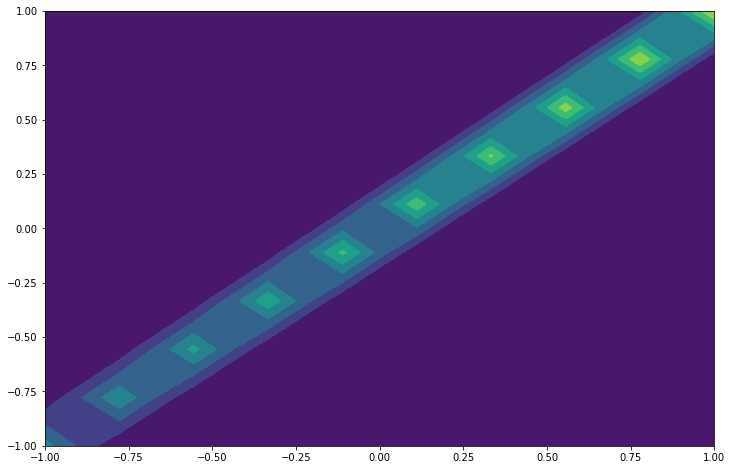

In [ ]:
import matplotlib.pyplot as plt

m = np.linspace(-1, 1, num=10)
xx, yy = np.meshgrid(m, m)
mesh = np.dstack((xx, yy)).reshape(-1, 2)

dens = tf.reshape(mvn.prob(mesh), shape=(m.shape[0], m.shape[0]))

plt.contourf(m, m, dens)

In [ ]:
y

<tf.Tensor: shape=(200, 1), dtype=int32, numpy=
array([[1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
    

In [ ]:
tf.math.sigmoid(f)

<tf.Tensor: shape=(200, 1), dtype=float64, numpy=
array([[0.48395801],
       [0.48128774],
       [0.47914282],
       [0.47753539],
       [0.4764736 ],
       [0.4759616 ],
       [0.47599934],
       [0.47658259],
       [0.47770286],
       [0.47934729],
       [0.4814987 ],
       [0.48413551],
       [0.4872318 ],
       [0.49075735],
       [0.49467777],
       [0.49895464],
       [0.50354575],
       [0.50840537],
       [0.51348466],
       [0.51873206],
       [0.52409378],
       [0.52951436],
       [0.5349372 ],
       [0.54030523],
       [0.54556146],
       [0.5506496 ],
       [0.55551465],
       [0.56010342],
       [0.56436501],
       [0.56825127],
       [0.57171714],
       [0.574721  ],
       [0.57722487],
       [0.57919469],
       [0.58060042],
       [0.58141624],
       [0.58162068],
       [0.58119671],
       [0.58013191],
       [0.57841864],
       [0.57605417],
       [0.57304087],
       [0.56938647],
       [0.56510417],
       [0.56021291],
     

In [ ]:
with tf.GradientTape() as tape:
  ngpc = -gpc_posterior(f, y, K)
  nmll = -compute_marginal_ll(f, y, tf.cast(k(x_grid), tf.float32), hess_diag)
tape.gradient(nmll, [f, k.trainable_variables])

[<tf.Tensor: shape=(200, 1), dtype=float32, numpy=
 array([[ -772.5556   ],
        [ -201.0639   ],
        [  213.2083   ],
        [  153.32002  ],
        [  545.0853   ],
        [  363.60873  ],
        [  390.21664  ],
        [ -459.41174  ],
        [  265.6429   ],
        [ -156.199    ],
        [  263.83395  ],
        [ -605.73224  ],
        [   65.227234 ],
        [  950.0456   ],
        [  -54.100628 ],
        [ -649.5994   ],
        [  155.39876  ],
        [  493.7262   ],
        [-1242.3228   ],
        [  -36.396126 ],
        [ 1028.8145   ],
        [ -925.4663   ],
        [   52.988544 ],
        [  -47.47816  ],
        [-1343.3793   ],
        [   59.232944 ],
        [  252.13057  ],
        [  -39.041958 ],
        [  452.57965  ],
        [ 1250.2305   ],
        [ -188.93306  ],
        [  -95.8463   ],
        [  454.72308  ],
        [  -65.30589  ],
        [-1316.1783   ],
        [ 1193.6177   ],
        [ -283.2562   ],
        [ -292.9817   ],

In [ ]:
marg_ll

[<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[9103780.]], dtype=float32)>,
 278.0638427734375,
 156.47727966308594,
 156.25267028808594,
 156.25267028808594,
 156.25267028808594,
 156.25267028808594,
 156.25267028808594,
 156.25267028808594,
 156.25267028808594,
 156.25267028808594]

In [ ]:
K = tf.cast(k(x_grid), tf.float32)
f = tf.Variable(f)
hess_diag = compute_hess_vec_obs_ll(f, y)

In [ ]:
x_grid_tf = tf.constant(x_grid, dtype=tf.float64)
K = tf.cast(k(x_grid_tf), dtype=tf.float32)

In [ ]:
k.trainable_variables

(<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=14.669790419156977>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-81.9588310210035>)

In [ ]:
compute_marginal_ll(f, y, K, hess_diag)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-292.66058]], dtype=float32)>

In [ ]:
### Optimize posterior
from gpflow.optimizers import NaturalGradient
from gpflow.optimizers import Scipy

opt = Scipy()

neg_post = []
marg_ll = []

x_grid_tf = tf.constant(x_grid, dtype=tf.float64)
K = tf.cast(k(x_grid_tf), dtype=tf.float32)

for i in range(10):
  opt_res = opt.minimize(lambda: -gpc_posterior(f, y, K), variables=[f])
  neg_post.append(opt_res.fun[0, 0])
  
  hess_diag = compute_hess_vec_obs_ll(f, y)

  opt_res = opt.minimize(
      lambda: -compute_marginal_ll(f, y, tf.cast(k(x_grid), tf.float32), hess_diag), 
      variables=k.trainable_variables)
  marg_ll.append(opt_res.fun[0, 0])
  print(i, 'mll', opt_res.fun[0,0])

0 mll 138.6294403076172
1 mll 138.6294403076172
2 mll 138.6294403076172
3 mll 138.6294403076172
4 mll 138.6294403076172
5 mll 138.6294403076172
6 mll 138.6294403076172
7 mll 138.6294403076172
8 mll 138.6294403076172
9 mll 138.6294403076172


In [ ]:
neg_post

[321.958984375,
 321.958984375,
 321.958984375,
 321.958984375,
 321.958984375,
 321.958984375,
 321.958984375,
 321.958984375,
 321.958984375,
 321.958984375]

In [ ]:
### optimize with custom training loop
import tensorflow.keras as tfk

opt_post = tfk.optimizers.Adam()
for i in range(10):
  with tf.GradientTape() as tape:
    ngpc = -gpc_posterior(f, y, K)
  
  grads = tape.gradient(ngpc, [f])
  opt_post.apply_gradients(zip(grads, [f]))

  print(i, ngpc)

0 tf.Tensor([[nan]], shape=(1, 1), dtype=float32)
1 tf.Tensor([[nan]], shape=(1, 1), dtype=float32)
2 tf.Tensor([[nan]], shape=(1, 1), dtype=float32)
3 tf.Tensor([[nan]], shape=(1, 1), dtype=float32)
4 tf.Tensor([[nan]], shape=(1, 1), dtype=float32)
5 tf.Tensor([[nan]], shape=(1, 1), dtype=float32)
6 tf.Tensor([[nan]], shape=(1, 1), dtype=float32)
7 tf.Tensor([[nan]], shape=(1, 1), dtype=float32)
8 tf.Tensor([[nan]], shape=(1, 1), dtype=float32)
9 tf.Tensor([[nan]], shape=(1, 1), dtype=float32)


In [ ]:
opt.minimize(
    lambda: -compute_marginal_ll(f, y, tf.cast(k(x_grid), tf.float32), hess_diag), 
    variables=k.trainable_variables)

      fun: array([[278.06384277]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  17.49926258, -103.72166781])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 21
      nit: 4
   status: 0
  success: True
        x: array([0.52897115, 1.85666415])

In [ ]:
with tf.GradientTape() as tape:
  K = tf.cast(k(x_grid), tf.float32)
  mll = compute_marginal_ll(f, y, K, hess_diag)

tape.gradient(mll, k.trainable_variables)

(<tf.Tensor: shape=(), dtype=float64, numpy=-2653.19322039523>,
 <tf.Tensor: shape=(), dtype=float64, numpy=132.7010788219566>)

In [ ]:
k.trainable_variables

(<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.5413248546129181>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.854586542131141>)

In [ ]:
k.trainable_parameters

(<Parameter: dtype=float64, shape=[], fn="softplus", numpy=1.0>,
 <Parameter: dtype=float64, shape=[], fn="softplus", numpy=2.0>)

In [ ]:
k.trainable_variables

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.5413248546129181>

In [ ]:
ttt = lambda: compute_marginal_ll(f, y, K, hess_diag)
ttt()

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-292.66058]], dtype=float32)>

In [ ]:
%%timeit
prod_vector = tf.repeat(1., repeats=f.shape[0])
prod_vector = tf.reshape(prod_vector, shape=(-1,1))

with tf.autodiff.ForwardAccumulator(
    f, prod_vector) as acc:
  with tf.GradientTape() as tape:
    obs_ll = tf.reduce_sum(obs_dist.log_prob(f, y))
  grad_obs_ll = tape.gradient(obs_ll, f)

tf.squeeze(acc.jvp(grad_obs_ll))

100 loops, best of 5: 15.7 ms per loop


In [ ]:
tf.reduce_sum(obs_dist.log_prob(f, y))

<tf.Tensor: shape=(), dtype=float32, numpy=-129.47101>

In [ ]:
tf.repeat(1, repeats=10)

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)>

In [ ]:
tf._hessian_vector_product

AttributeError: ignored

### TP Binary Classification

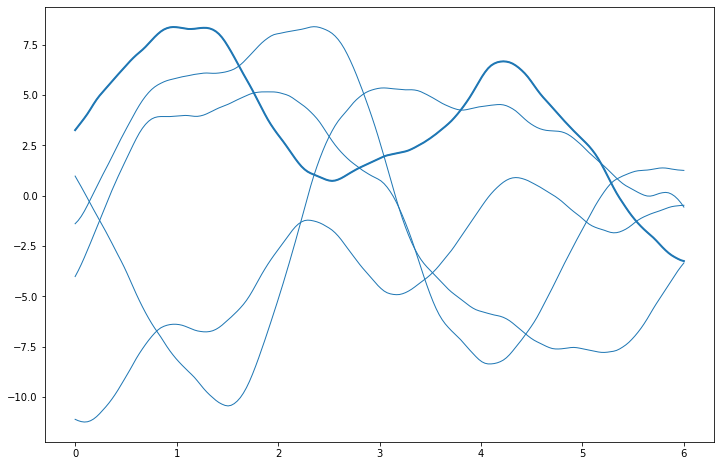

In [ ]:
# build the kernel and covariance matrix
k = gpflow.kernels.Matern52(variance=20.0)
x_grid = np.linspace(0, 6, 200).reshape(-1, 1)
K = k(x_grid)

# sample from a multivariate normal
rng = np.random.RandomState(6)

L = np.linalg.cholesky(K)
f_grid = np.dot(L, rng.randn(200, 5))
plt.plot(x_grid, f_grid, "C0", linewidth=1)
_ = plt.plot(x_grid, f_grid[:, 1], "C0", linewidth=2)

In [ ]:
### Sample from TP
# Based on https://journal.r-project.org/archive/2013/RJ-2013-033/RJ-2013-033.pdf
nu = 5

k = gpflow.kernels.Matern52(variance=20.0)
x_grid = np.linspace(0, 6, 400).reshape(-1, 2)
K = k(x_grid)

# sample from a multivariate normal
rng = np.random.RandomState(6)
f_grid = np.dot(L, rng.randn(200, 5))

L = np.linalg.cholesky(K)

chi2 = tfd.Chi2(df=nu)
samples_chi2 = chi2.sample(sample_shape=x_grid.shape[0])

scaler = tf.sqrt(nu/samples_chi2)
scaler = tf.reshape(scaler, shape=(-1,1))

t_samples = tf.multiply(scaler, f_grid)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
  after removing the cwd from sys.path.


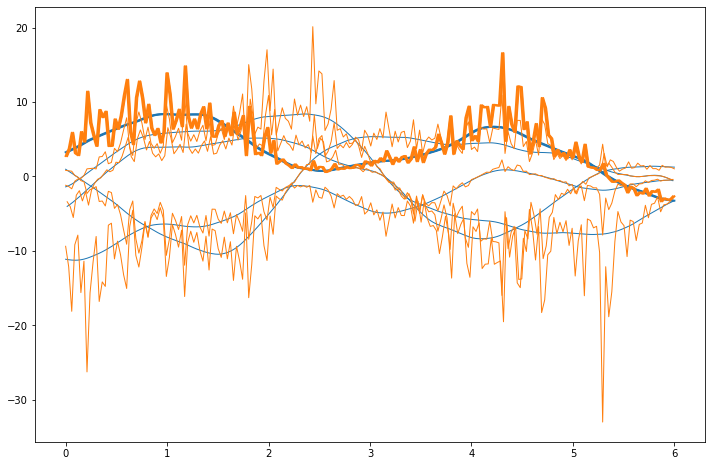

In [ ]:
plt.plot(x_grid, f_grid, "C0", linewidth=1)
_ = plt.plot(x_grid, f_grid[:, 1], "C0", linewidth=2)
_ = plt.plot(x_grid, t_samples[:, 1], "C1", linewidth=2)
_ = plt.plot(x_grid, t_samples, "C1", linewidth=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.


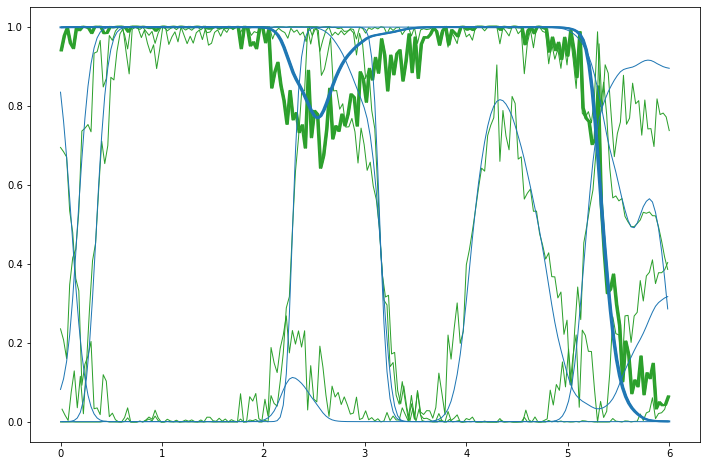

In [ ]:
def invlink(f):
    # By default, standard normal CDF is used as link function, but 
    # any other function can be used as well, just set invlink argument
    # of Bernoulli()
    return gpflow.likelihoods.Bernoulli().invlink(f).numpy()

def student_invlink(f):
    # By default, standard normal CDF is used as link function, but 
    # any other function can be used as well, just set invlink argument
    # of Bernoulli()
    return gpflow.likelihoods.Bernoulli(invlink=tf.math.sigmoid) \
                 .invlink(f).numpy()

p_grid = student_invlink(t_samples)
plt.plot(x_grid, p_grid, "C2", linewidth=1)
_ = plt.plot(x_grid, p_grid[:, 1], "C2", linewidth=2)

p_grid = invlink(f_grid)
plt.plot(x_grid, p_grid, "C0", linewidth=1)
_ = plt.plot(x_grid, p_grid[:, 1], "C0", linewidth=2)

In [ ]:
nu = 2


tf.sqrt(nu/chi2.sample(sample_shape=x_grid.shape[0]))



<tf.Tensor: shape=(200,), dtype=float32, numpy=
array([ 1.3007921 ,  0.5945616 ,  4.140359  ,  0.5236784 ,  1.0546414 ,
        2.3277607 ,  0.6428949 ,  0.87101114,  2.139834  ,  1.0765688 ,
        0.48967543,  0.83307487,  1.4357847 ,  0.84297323,  1.4021976 ,
        2.0693488 ,  0.7149594 ,  2.031121  ,  0.90849364,  1.0859494 ,
        1.3602829 ,  1.5546957 ,  1.1186092 ,  2.6291556 ,  1.5865874 ,
        1.2005293 ,  3.746406  ,  1.9046172 ,  0.9871173 ,  1.5947839 ,
        1.053179  ,  2.8627064 ,  3.998484  ,  0.9493354 ,  2.3621824 ,
        0.5116686 ,  1.1282829 ,  1.2950402 ,  2.1322181 ,  0.9792082 ,
        2.082827  ,  0.55384165,  1.8508312 ,  3.751865  ,  8.078958  ,
        0.9400194 ,  1.6236022 ,  8.167329  ,  0.4386076 ,  0.9109911 ,
        1.3400762 ,  1.1491632 ,  0.63242054,  1.521914  ,  1.314498  ,
        0.592963  ,  0.6141043 ,  2.804778  ,  0.6605994 ,  0.9502515 ,
        0.7335708 ,  1.1584921 ,  0.72806495,  4.295151  ,  1.6300067 ,
        3.666576

### TPC t-Laplace Approximation

In [ ]:
! pip install gpflow

     |████████████████████████████████| 271 kB 15.5 MB/s 


In [ ]:
import gpflow
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

plt.rcParams["figure.figsize"] = (12, 8)

tf.__version__

PI = tf.constant(np.pi, dtype=tf.float64)
obs_dist = gpflow.likelihoods.Bernoulli(invlink=tf.math.sigmoid)

def get_t(nu, nobs):
  return 2/(nu + nobs) + 1

def log_t(x, t):
  if t == 1:
    return tf.math.log(x)
  else:
    one_min_t = 1 - t
    return (x**one_min_t - 1) / one_min_t

def get_psi(t, nu, nobs, half_log_det_X):
  psi = (1. - t)*(
      tf.math.lgamma((nu + nobs)/2.) 
      - nobs/2 * (PI*nu)
      - tf.math.lgamma(nu/2.)
      - half_log_det_X
  )
  return tf.exp(psi)

#log_t approximation to posterior
def tpc_posterior(f, y, chol_K, nu, t, psi):
  fK = tf.linalg.cholesky_solve(chol_K, f)
  
  one_min_t_div = 1/(1-t)

  psi_div = psi * one_min_t_div

  ll = (
    tf.reduce_sum(log_t(tf.exp(obs_dist.log_prob(f, y)), t))
    + psi_div
    + psi_div*(1/nu)*tf.matmul(fK, fK, transpose_a=True)
    - one_min_t_div
  )

  return ll#, tf.reduce_sum(log_t(tf.exp(obs_dist.log_prob(f, y)), t)), psi_div, psi_div*(1/nu), tf.matmul(fK, fK, transpose_a=True), one_min_t_div

def compute_posterior_covariance(K, w):
  sqrt_w = tf.sqrt(w)
  sqrt_w_t = tf.reshape(sqrt_w, shape=(-1, 1))

  K_sqrt_w = tf.multiply(K, sqrt_w)
  B = tf.eye(K.shape[0]) + tf.multiply(sqrt_w_t, K_sqrt_w)
  
  chol_B = tf.linalg.cholesky(B)
  K_sqrt_w_t = tf.transpose(K_sqrt_w)
  inv_sqrt_B_sqrt_w_K = tf.linalg.cholesky_solve(chol_B, K_sqrt_w_t)

  cov_mat = K - tf.matmul(
      inv_sqrt_B_sqrt_w_K, inv_sqrt_B_sqrt_w_K, transpose_a=True)
  
  return cov_mat

def get_C(f, y, chol_K, nu, t, psi):
  logt_posterior = tpc_posterior(f, y, chol_K, nu, t, psi)
  C = 1 + (1 - t)*logt_posterior

  return C

def get_tau(f, y, chol_K, nu, t, psi):
  C = get_C(f, y, chol_K, nu, t, psi)
  tau = - (
      2*C/(1 - t)
  )
  return tau

def compute_posterior_scaling_mat(K, w, tau, psi, t, nu):

  scaler_cov = tau/nu
  scaler_c = (t - 1)*nu / (2*psi)

  # TODO: Check whether -w is the correct one.
  sqrt_w = tf.sqrt(-w)
  sqrt_w_t = tf.reshape(sqrt_w, shape=(-1, 1))

  K_sqrt_w = tf.multiply(K, sqrt_w)
  B = tf.eye(K.shape[0], dtype=tf.float64) + scaler_c*tf.multiply(sqrt_w_t, K_sqrt_w)
  
  # TODO: Check whether this transpose makes sense
  chol_B = tf.linalg.cholesky(B)
  K_sqrt_w_t = tf.transpose(K_sqrt_w)
  inv_sqrt_B_sqrt_w_K = tf.linalg.cholesky_solve(chol_B, K_sqrt_w_t)

  cov_mat = scaler_c*K - (scaler_c**2)*tf.matmul(
      inv_sqrt_B_sqrt_w_K, inv_sqrt_B_sqrt_w_K, transpose_a=True)
  
  return scaler_cov*cov_mat

def compute_hess_vec_obs_ll(f, y):
  prod_vector = tf.repeat(tf.cast(1., dtype=tf.float64), repeats=f.shape[0])
  prod_vector = tf.reshape(prod_vector, shape=(-1,1))

  with tf.autodiff.ForwardAccumulator(
      f, prod_vector) as acc:
    with tf.GradientTape() as tape:
      obs_ll = tf.reduce_sum(obs_dist.log_prob(f, y))
    grad_obs_ll = tape.gradient(obs_ll, f)

  hess_vec = acc.jvp(grad_obs_ll)
  return tf.squeeze(hess_vec)

def compute_marginal_ll(f, y, K, hess_diag, t, nu):
  nobs = K.shape[0]
  
  pad_K = K + 10e-6*tf.eye(nobs, dtype=tf.float64)
  chol_K = tf.linalg.cholesky(pad_K)
  half_log_det_K = tf.math.log(tf.reduce_sum(tf.linalg.diag_part(chol_K)))
  
  psi = get_psi(t, nu, nobs, half_log_det_K)
  tau = get_tau(f, y, chol_K, nu, t, psi)
  scaling_mat = compute_posterior_scaling_mat(pad_K, hess_diag, tau, psi, t, nu)

  C = get_C(f, y, chol_K, nu, t, psi)

  chol_A = tf.linalg.cholesky(scaling_mat)
  half_log_det_A = tf.math.log(tf.reduce_sum(tf.linalg.diag_part(chol_A)))

  marg_ll = (1 / (1 - t)) * (
      tf.math.log(C)
      + 0.5*nobs*tf.math.log(PI*tau)
      + tf.math.lgamma(0.5*nu)
      + half_log_det_A
      - tf.math.lgamma(0.5*(nu + nobs))
  )

  return marg_ll
'''
def compute_marginal_ll(f, y, K, hess_diag):
  sqrt_w = tf.sqrt(-hess_diag)
  sqrt_w_t = tf.reshape(sqrt_w, shape=(-1, 1))

  K_sqrt_w = tf.multiply(K, sqrt_w)
  B = tf.eye(K.shape[0]) + tf.multiply(sqrt_w_t, K_sqrt_w)
  chol_B = tf.linalg.cholesky(B)

  chol_K = tf.linalg.cholesky(K  + 10e-5*tf.eye(K.shape[0]))
  inv_chol_K_f = tf.linalg.cholesky_solve(chol_K, f)

  mll = (
      - 0.5*tf.tensordot(inv_chol_K_f, inv_chol_K_f, axes=(0, 0))
      + tf.reduce_sum(obs_dist.log_prob(f, y))
      - tf.reduce_sum(tf.math.log(tf.linalg.diag_part(chol_B)))
  )
  
  return mll
'''
k = gpflow.kernels.SquaredExponential(lengthscales=1, variance=2.)
x_grid = np.linspace(0, 6, 200).reshape(-1, 1)
K = k(x_grid)

# sample from a multivariate normal
rng = np.random.RandomState(6)

L = np.linalg.cholesky(K + 10e-6*np.eye(K.shape[0]))
f_real = np.dot(L, rng.randn(200, 1))
f_real = tf.cast(f, tf.float64)
pvals = obs_dist.invlink(f_real)
y = tf.cast(rng.binomial(1, pvals), tf.int32)


In [ ]:
x_grid_tf = tf.constant(x_grid, dtype=tf.float64)
K = tf.cast(k(x_grid_tf), dtype=tf.float32)

nu = tf.constant(2.)
nobs = K.shape[0]
t = get_t(nu, nobs)

pad_K = K + 10e-5*tf.eye(nobs)
chol_K = tf.linalg.cholesky(pad_K)
half_log_det_K = tf.math.log(tf.reduce_sum(tf.linalg.diag_part(chol_K)))

psi = get_psi(t, nu, nobs, half_log_det_K)
tau = get_tau(f, y, chol_K, nu, t, psi) 

tpc_posterior(f, y, chol_K, nu=2.0, t=t, psi=psi)

InvalidArgumentError: ignored

In [ ]:
get_t(nu, nobs)

<tf.Tensor: shape=(), dtype=float32, numpy=1.009901>

In [ ]:
### Optimize posterior
'''
from gpflow.optimizers import NaturalGradient
from gpflow.optimizers import Scipy

opt = Scipy()

neg_post = []
marg_ll = []

x_grid_tf = tf.constant(x_grid, dtype=tf.float64)
K = tf.cast(k(x_grid_tf), dtype=tf.float32)

nu = tf.constant(2.)
nobs = K.shape[0]
t = get_t(nu, nobs)

for i in range(10):

  K = tf.cast(k(x_grid_tf), dtype=tf.float32)
  nobs = K.shape[0]
  t = get_t(nu, nobs)

  pad_K = K + 10e-5*tf.eye(nobs)
  chol_K = tf.linalg.cholesky(pad_K)
  half_log_det_K = tf.math.log(tf.reduce_sum(tf.linalg.diag_part(chol_K)))

  psi = get_psi(t, nu, nobs, half_log_det_K)
  tau = get_tau(f, y, chol_K, nu, t, psi) 

  opt_res = opt.minimize(lambda: -tpc_posterior(f, y, chol_K, nu, t, psi), variables=[f])
  neg_post.append(opt_res.fun[0, 0])
  
  hess_diag = compute_hess_vec_obs_ll(f, y)

  opt_res = opt.minimize(
      lambda: -compute_marginal_ll(f, y, tf.cast(k(x_grid) + 10e-6*tf.eye(nobs, dtype=tf.float64), tf.float32), hess_diag, t, nu), 
      variables=k.trainable_variables)
  marg_ll.append(opt_res.fun[0, 0])
  print(i, 'mll', opt_res.fun[0,0])
'''

0 mll 57889.08984375
1 mll 57789.08203125


InvalidArgumentError: ignored

In [ ]:
### Optimize posterior
from gpflow.optimizers import NaturalGradient
from gpflow.optimizers import Scipy

opt = Scipy()

neg_post = []
marg_ll = []

x_grid_tf = tf.constant(x_grid, dtype=tf.float64)
K = k(x_grid_tf)

nu = tf.constant(2., dtype=tf.float64)
nobs = K.shape[0]
t = get_t(nu, nobs)

f = tf.Variable(np.random.normal(size=y.shape))

for i in range(100):

  K = k(x_grid_tf)
  nobs = K.shape[0]
  t = get_t(nu, nobs)

  pad_K = K + 10e-6*tf.eye(nobs, dtype=tf.float64)
  chol_K = tf.linalg.cholesky(pad_K)
  half_log_det_K = tf.math.log(tf.reduce_sum(tf.linalg.diag_part(chol_K)))

  psi = get_psi(t, nu, nobs, half_log_det_K)
  tau = get_tau(f, y, chol_K, nu, t, psi) 

  opt_res = opt.minimize(lambda: -tpc_posterior(f, y, chol_K, nu, t, psi), variables=[f])
  neg_post.append(opt_res.fun[0, 0])
  if i % 10 == 0:
    print(i, 'neg-post', opt_res.fun[0,0])
  
  hess_diag = compute_hess_vec_obs_ll(f, y)

  opt_res = opt.minimize(
      lambda: -compute_marginal_ll(f, y, k(x_grid), hess_diag, t, nu), 
      variables=k.trainable_variables)
  marg_ll.append(opt_res.fun[0, 0])
  if i % 10 == 0:
    print(i, 'mll', opt_res.fun[0,0])

0 neg-post 1718.7081620524664
0 mll 56511.280977392125
10 neg-post 1456.4610408353708
10 mll 56501.62908225023
20 neg-post 1456.4339931952125
20 mll 56498.07128906822
30 neg-post 1456.124761903146
30 mll 56496.02232901107
40 neg-post 1456.097230052789
40 mll 56494.40452170488
50 neg-post 1456.0884488331608
50 mll 56493.473019037694
60 neg-post 1456.085082000135
60 mll 56492.72071944924
70 neg-post 1455.9802169420657
70 mll 56492.065753744704
80 neg-post 1455.886146478877
80 mll 56491.476864523014
90 neg-post 1455.8562747104963
90 mll 56491.296155935845


In [ ]:
import numpy as np
np.linalg.eigvals(pad_K)

array([ 2.14627988e+04,  2.74400681e-01,  9.58264864e-05,  9.56749427e-05,
       -4.08293163e-05, -4.05855462e-05,  8.33350205e-05,  8.33554586e-05,
       -3.63959080e-05, -3.59788755e-05, -3.55767770e-05, -3.55221346e-05,
       -3.44458858e-05, -3.35642908e-05, -3.09299721e-05, -3.00818610e-05,
        7.59975810e-05,  7.50513864e-05,  6.96477437e-05,  7.39427778e-05,
        7.38910894e-05,  7.38310991e-05,  7.30993779e-05,  7.28717932e-05,
        7.21175602e-05,  7.25891077e-05,  7.22676705e-05,  7.22670447e-05,
       -2.85847982e-05, -2.82364344e-05, -2.94700785e-05, -2.94232796e-05,
        6.87427964e-05,  6.74558469e-05,  6.73472096e-05, -2.59535100e-05,
        6.49099675e-05,  6.46413246e-05,  6.35691904e-05,  6.15364188e-05,
        6.24874374e-05,  6.24577660e-05, -2.54749102e-05, -2.47761491e-05,
       -2.46886830e-05, -2.43413688e-05, -2.39872788e-05, -2.22875569e-05,
       -1.97844292e-05, -2.13336971e-05, -2.05839442e-05, -2.08955389e-05,
       -1.92080734e-05,  

In [ ]:
np.linalg.eigvals(k(x_grid).numpy() + 10e-6*np.eye(K.shape[0]))

array([1.51178110e+02+0.00000000e+00j, 1.13820238e+02+0.00000000e+00j,
       7.13196240e+01+0.00000000e+00j, 3.75055813e+01+0.00000000e+00j,
       1.67412387e+01+0.00000000e+00j, 6.42745204e+00+0.00000000e+00j,
       2.15198878e+00+0.00000000e+00j, 6.36571920e-01+0.00000000e+00j,
       1.68293450e-01+0.00000000e+00j, 4.01628231e-02+0.00000000e+00j,
       8.72974650e-03+0.00000000e+00j, 1.74589588e-03+0.00000000e+00j,
       3.28768642e-04+0.00000000e+00j, 6.42898365e-05+0.00000000e+00j,
       1.86164625e-05+0.00000000e+00j, 1.12798130e-05+0.00000000e+00j,
       1.01785705e-05+0.00000000e+00j, 1.00234847e-05+0.00000000e+00j,
       1.00029201e-05+0.00000000e+00j, 1.00003442e-05+0.00000000e+00j,
       1.00000386e-05+0.00000000e+00j, 1.00000041e-05+0.00000000e+00j,
       1.00000004e-05+0.00000000e+00j, 9.99999992e-06+0.00000000e+00j,
       1.00000001e-05+0.00000000e+00j, 1.00000000e-05+0.00000000e+00j,
       1.00000000e-05+0.00000000e+00j, 9.99999996e-06+0.00000000e+00j,
      

In [ ]:
tf.linalg.cholesky(tf.cast(k(x_grid) + 10e-6*tf.eye(nobs, dtype=tf.float64), tf.float32))

<tf.Tensor: shape=(200, 200), dtype=float32, numpy=
array([[1.4142171e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.4135673e+00, 4.2865977e-02, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.4116411e+00, 8.4947720e-02, 7.9561379e-03, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [3.0871327e-08, 1.9966559e-07, 2.2741082e-07, ..., 4.3336716e-03,
        0.0000000e+00, 0.0000000e+00],
       [2.5797739e-08, 1.6777685e-07, 1.9207184e-07, ..., 2.7117000e-03,
        4.3035704e-03, 0.0000000e+00],
       [2.1538389e-08, 1.4084928e-07, 1.6207078e-07, ..., 3.4372690e-03,
        2.6772921e-03, 4.3361648e-03]], dtype=float32)>

In [ ]:
tf.linalg.cholesky(tf.cast(k(x_grid) + 10e-6*tf.eye(K.shape[0], dtype=tf.float64), tf.float32))

<tf.Tensor: shape=(200, 200), dtype=float32, numpy=
array([[1.4142171e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.4135673e+00, 4.2865977e-02, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.4116411e+00, 8.4947720e-02, 7.9561379e-03, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [3.0871327e-08, 1.9966559e-07, 2.2741082e-07, ..., 4.3336716e-03,
        0.0000000e+00, 0.0000000e+00],
       [2.5797739e-08, 1.6777685e-07, 1.9207184e-07, ..., 2.7117000e-03,
        4.3035704e-03, 0.0000000e+00],
       [2.1538389e-08, 1.4084928e-07, 1.6207078e-07, ..., 3.4372690e-03,
        2.6772921e-03, 4.3361648e-03]], dtype=float32)>

In [ ]:
mat = k(x_grid).numpy()

In [ ]:
mat[0, 5], mat[5, 0]

(1.9774019391752014, 1.9774019391752014)